In [1]:
import tiktoken
import torch
import os
import urllib.request

from previous_chapters import GPTModel, create_dataloader_v1, generate_text_simple

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, 
            idx=encoded,
            max_new_tokens=50, 
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [2]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data (Raw) ################# 
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

print(text_data[:99])

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

### Dataloader #####################

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

### Model, Tokenizer, Optimizer.
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
tokenizer = tiktoken.get_encoding("gpt2")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

### Train Loop.
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    device,
    num_epochs=num_epochs, 
    eval_freq=5, 
    eval_iter=5,
    start_context="Every effort moves you", 
    tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
Ep 1 (Step 000000): Train loss 9.821, Val loss 9.931
Ep 1 (Step 000005): Train loss 8.069, Val loss 8.334
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.049
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.598
Every effort moves you, and,, and,,,,,,,,,.                                   
Ep 3 (Step 000020): Train loss 5.558, Val loss 6.503
Ep 3 (Step 000025): Train loss 5.471, Val loss 6.392
Every effort moves you, and to the to the of the to the, and I had. Gis, and I had, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.995, Val loss 6.275
Ep 4 (Step 000035): Train loss 4.756, Val loss 6.289
Every effort moves you, and I had been the picture.                    "I"I the the donkey of the donkey the donkey of the picture and I had been a"I
Ep 5 (Step 000040):

In [3]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [4]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [6]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
print(f"probas:{probas}. sum:{sum(probas)}")

next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

probas:tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03]). sum:0.9999998807907104
forward


In [7]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [8]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    print(f"sampled_ids:{sampled_ids}")

    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

sampled_ids:tensor([ 73,   0,   0, 582,   2,   0,   0, 343,   0])
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


In [13]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]


tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

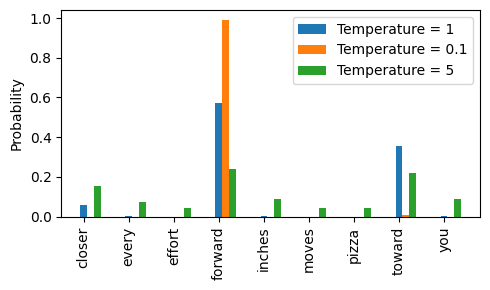

In [14]:
import matplotlib.pyplot as plt

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [15]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [16]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [18]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youlit," she up surprise. It is to face watching me by his knees
